In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import pandas as pd

import glidar_parse
from glidar_parse import sci_track

from scipy.ndimage import gaussian_filter1d

In [2]:
file = os.path.abspath('../data/single-flight/2019-Bavallen628175.kml')
file

'C:\\Users\\duro2\\Work\\glidar-parse\\data\\single-flight\\2019-Bavallen628175.kml'

In [3]:
parser = glidar_parse.parse_file(file, )
s_track = sci_track.SciTrack(parser, sigma=5, tau=1)
track = s_track.track

dc = np.gradient(track.course)

dc = [ e if abs(e) < abs(e + np.pi) else e + np.pi for e in dc  ]
dc = [ e if abs(e) < abs(e - np.pi) else e - np.pi for e in dc  ]

track['dc'] = dc

C = np.cumsum(np.abs(gaussian_filter1d(track.dc, 10)))

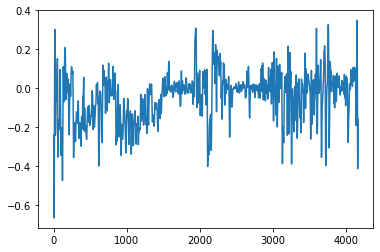

In [4]:
plt.plot(gaussian_filter1d(track.dc, 3))


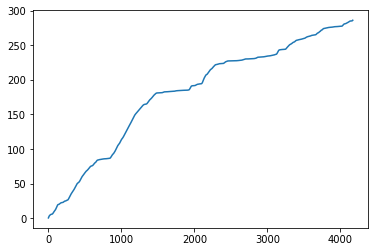

In [5]:
plt.plot(gaussian_filter1d(C,1))

In [6]:
DC = C[2:] - C[:-2]

(4171,) (4171,)


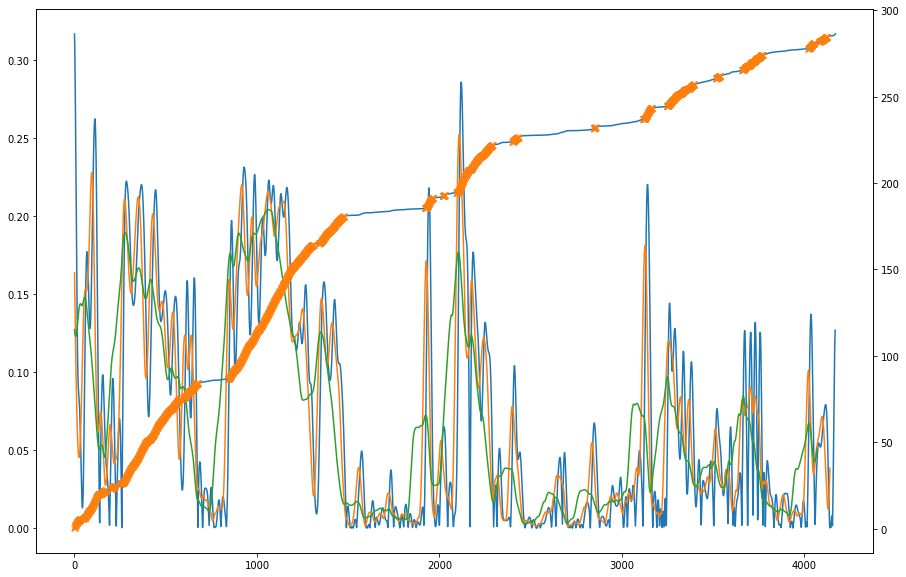

In [7]:
plt.figure(figsize=(15,10))

for i in [1, 30, 100]:
    plt.plot((C[i:] - C[:-i]) / i)
    
ax2=plt.gca().twinx()

i = 30
mask = np.pad((C[i:] - C[:-i]) / i,  i//2, mode='edge') > 0.05

ax2.plot(C)
ax2.plot(np.arange(0,C.shape[0])[mask], C[mask], 'x')

track['turning'] = mask
    
# plt.plot(np.abs(dc))

In [8]:
np.arange(1,C.shape[0]).shape

(4170,)

# Computing the circle fit again ...



In [9]:
res = s_track.compute_wind(track.dx, track.dy, 60)

In [10]:
res

{'radius': array([3.00917139, 3.00917139, 3.00917139, ..., 5.08007861, 5.08007861,
        5.08007861]),
 'center': array([[ 1.91294572,  2.36164657],
        [ 1.91294572,  2.36164657],
        [ 1.91294572,  2.36164657],
        ...,
        [-2.16083601,  3.40542429],
        [-2.16083601,  3.40542429],
        [-2.16083601,  3.40542429]]),
 'speed': array([3.03919987, 3.03919987, 3.03919987, ..., 4.03312867, 4.03312867,
        4.03312867])}

In [11]:
res['center'].shape

(4171, 2)

In [12]:
track['wind_x'] = res['center'][:,0]
track['wind_y'] = res['center'][:,1]

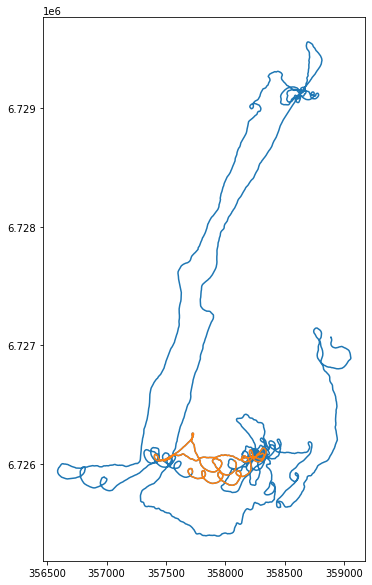

In [16]:
subtrack = (track.copy().iloc[500:1100])

plt.figure(figsize=(15,10))
plt.plot(track.x, track.y)
plt.plot(subtrack.x, subtrack.y)
plt.gca().set_aspect('equal')
plt.show()

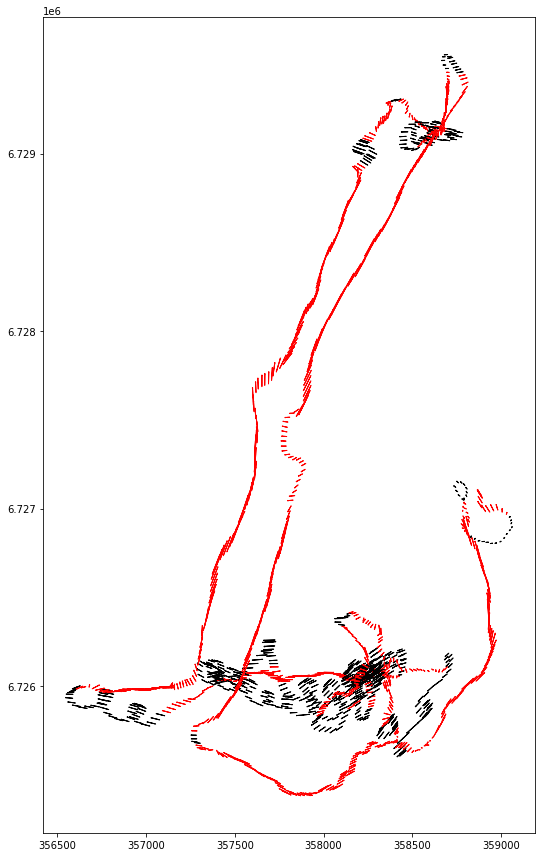

In [20]:
subtrack['x'] -= subtrack.x.mean()
subtrack['y'] -= subtrack.y.mean()

subtrack['dxx'] = np.pad(subtrack.x.values[2:] - subtrack.x.values[:-2], 1, mode='edge') / subtrack.dt
subtrack['dyy'] = np.pad(subtrack.y.values[2:] - subtrack.y.values[:-2], 1, mode='edge') / subtrack.dt


k = 10 

a = track.iloc[::3]
plt.figure(figsize=(15,15))

for index, e in a.iterrows():    
    plt.arrow(e.x, e.y, k * e.wind_x, k *  e.wind_y, head_width=3, color=( 'black' if e.turning else 'red'))

    
# plt.plot(track.x, track.y, 'x-')
plt.gca().set_aspect('equal')
plt.show()

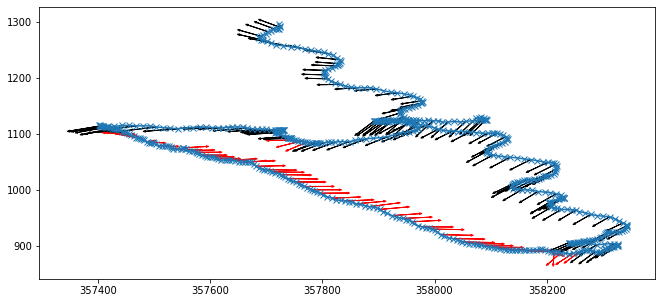

In [17]:
plt.figure(figsize=(15,5))

plt.plot(subtrack.x, subtrack.altitude, '-x')
a = subtrack.iloc[::3]
for index, e in a.iterrows():    
    plt.arrow(e.x, e.altitude, 10 * e.wind_x, 10 * e.wind_y, head_width=3, color=( 'black' if e.turning else 'red'))

plt.gca().set_aspect('equal')


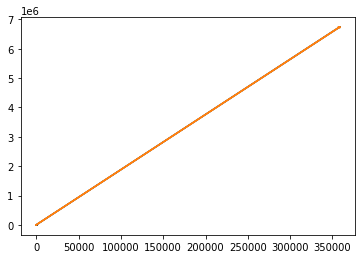

In [16]:
def plot_smooth(df, sigma):
    
    df['sx'] = gaussian_filter1d(df.x, sigma)
    df['sy'] = gaussian_filter1d(df.y, sigma)
    
    plt.plot(df.sx, df.sy)
    plt.plot(df.x, df.y)
    
    k = 3 
    a = df.iloc[::1]
    for index, e in a.iterrows():    
        plt.arrow(e.sx, e.sy, k * e.dx, k *  e.dy, head_width=3)
    plt.show()
    
plot_smooth(track, 3)

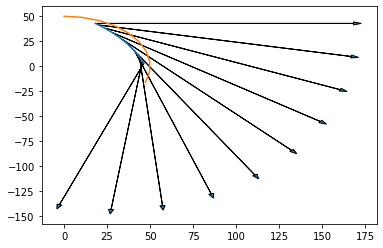

In [17]:
R = 50
time = 10
period = 33    # sec to turn a circle 

sigma = 3

t = np.linspace(0, np.pi * 2 * time / period, time)
s = R * np.sin(t)
c = R * np.cos(t)

df = pd.DataFrame((s,c, c, -s), ['x', 'y', 'dx', 'dy']).T

plot_smooth(df,sigma)

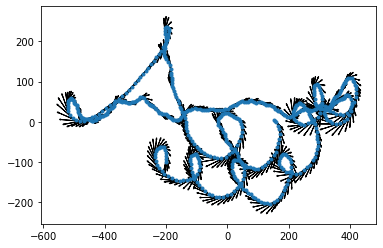

In [18]:
def plot_arrows(track):
    plt.plot(track.x, track.y, '.')

    k = 5

    a = track.iloc[::1]
    for index, e in a.iterrows():    
        plt.arrow(e.x, e.y, k * e.dx, k *  e.dy, head_width=3)
    plt.show()
    
plot_arrows(subtrack)